# Data Analysis

## Load Data

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

pd.set_option("display.max_columns", None)


account = pd.read_csv('data/account.csv', dtype={'date':object})
card_dev = pd.read_csv('data/card_dev.csv', dtype={'issued':object})
client = pd.read_csv('data/client.csv', dtype={'birth_number':object})
disposition = pd.read_csv('data/disp.csv')
district = pd.read_csv('data/district.csv')
loan_dev = pd.read_csv('data/loan_dev.csv', dtype={'date':object})
trans_dev = pd.read_csv('data/trans_dev.csv', 
                        dtype={'account_id':int, 'date':object, 'type':object, 'operation':object, 'amount':float, 'balance':float, 'k_symbol':object, 'bank':object, 'account':float})

data = pd.read_csv('data_processed/data.csv')

## General Attribute Analysis

The data is organized in data tables so each table has an ammount of attributes that can be analised to better understand their significance.

In [ ]:
print(f'''
account     shape: {account.shape}
client      shape: {client.shape}
disposition shape: {disposition.shape}
district    shape: {district.shape}
card        shape: {card_dev.shape}
loan        shape: {loan_dev.shape}
trans       shape: {trans_dev.shape}

data        shape: {data.shape}
''')

In [ ]:
display(account.head(), 'Account')
display(card_dev.head(), 'Card')
display(client.head(), 'Client')
display(disposition.head(), 'Disposition')
display(district.head(), 'District')
display(loan_dev.head(), 'Loan')
display(trans_dev.head(), 'Transaction')

In [ ]:
print('Account')
print(account.info())
print('\nCard')
print(card_dev.info())
print('\nClient')
print(client.info())
print('\nDisposition')
print(disposition.info())
print('\nDistrict')
print(district.info())
print('\nLoan')
print(loan_dev.info())
print('\nTransaction')
print(trans_dev.info())

### String object type analysis

In [ ]:
account_frequency = account["frequency"].value_counts()
card_type = card_dev["type"].value_counts()
disp_type = disposition["type"].value_counts()
district_name = district["name"].value_counts()
district_region = district["region"].value_counts()
trans_type = trans_dev["type"].value_counts()
trans_operation = trans_dev["operation"].value_counts()
trans_k_symbol = trans_dev["k_symbol"].value_counts()
trans_bank = trans_dev["bank"].value_counts()


display(account_frequency)
display(card_type)
display(disp_type)
display(district_name)
display(district_region)
display(trans_type)
display(trans_operation)
display(trans_k_symbol)
display(trans_bank)

In [ ]:
plt.title("Account Frequency")
plt.bar(list(account_frequency.keys()), list(account_frequency))

plt.figure()
plt.title("Card Type")
plt.bar(list(card_type.keys()), list(card_type))

plt.figure()
plt.title("Disposition Type")
plt.bar(list(disp_type.keys()), list(disp_type))

plt.figure(figsize=[6.4, 20])
plt.title("District Name")
plt.barh(list(district_name.keys()), list(district_name))

plt.figure()
plt.title("District Region")
plt.barh(list(district_region.keys()), list(district_region))

plt.figure()
plt.title("Transaction Type")
plt.bar(list(trans_type.keys()), list(trans_type))

plt.figure()
plt.title("Transaction Operation")
plt.barh(list(trans_operation.keys()), list(trans_operation))

plt.figure()
plt.title("Transaction K_symbol")
plt.barh(list(trans_k_symbol.keys()), list(trans_k_symbol))

plt.figure()
plt.title("Transaction Bank")
plt.bar(list(trans_bank.keys()), list(trans_bank))

- District Name has no significance, it could be an id
- Transaction k_symbol has empty values besides NaN

### Statitical Methods

In [ ]:
print('Account')
display(account.describe())
print('\nCard')
display(card_dev.describe())
print('\nClient')
display(client.describe())
print('\nDisposition')
display(disposition.describe())
print('\nDistrict')
display(district.describe())
print('\nLoan')
display(loan_dev.describe())
print('\nTransaction')
display(trans_dev.describe())

In [ ]:
# Describe mean balance for each account

balance_mean_by_account = trans_dev.groupby('account_id')['balance'].mean()
display(balance_mean_by_account.describe())


In [ ]:
# Describe mean transaction amount for each transaction type

amount_mean_by_transaction_type = trans_dev.groupby('type')['amount'].mean()
display(amount_mean_by_transaction_type)

amount_mean_by_transaction_operation = trans_dev.groupby('operation')['amount'].mean()
display(amount_mean_by_transaction_operation)

In [ ]:
# Analyse transactions during the time of each loan

loan_clone = loan_dev.copy()
trans_clone = trans_dev.copy()

loan_clone['date'] = loan_clone['date'].apply(lambda x: '19'+x[:2]+'-'+x[2:4]+'-'+x[4:])
loan_clone['date'] = pd.to_datetime(loan_clone['date'])

trans_clone['date'] = trans_clone['date'].apply(lambda x: '19'+x[:2]+'-'+x[2:4]+'-'+x[4:])
trans_clone['date'] = pd.to_datetime(trans_clone['date'])

loan_trans = pd.merge(loan_clone, trans_clone, left_on='account_id', right_on='account_id', how='left')
loan_trans['date_diff'] = (loan_trans['date_y']-loan_trans['date_x'])/np.timedelta64(1, 'M')
loan_trans['date_diff'] = loan_trans['date_diff'].astype(int)

def agg_func(data):
    credits = data[(data['type'] == 'credit') & (data['operation'] != 'collection from another bank')]
    withdrawals = data[((data['type'] == 'withdrawal') | (data['type'] == 'withdrawal in cash')) & (data['operation'] != 'remittance to another bank')]
    return pd.Series({
        'account_id': data['account_id'].iat[0].astype(int),
        'credit_count': credits.shape[0],
        'withdrawal_count': withdrawals.shape[0],
        'mensal_credit': (credits['amount_y'].sum() / (credits['date_diff'].iat[-1] - credits['date_diff'].iat[0] + 1)) if credits.shape[0] != 0 else 0, 
        'mensal_withdrawal': (withdrawals['amount_y'].sum() / (withdrawals['date_diff'].iat[-1] - withdrawals['date_diff'].iat[0] + 1)) if withdrawals.shape[0] != 0 else 0,
        'last_balance': data['balance'].iat[-1],
        'status': data['status'].iat[0],
        'payments': data['payments'].iat[0],
        'amount': data['amount_x'].iat[0],
        'duration': data['duration'].iat[0],
    })
res = loan_trans.groupby(['loan_id']).apply(agg_func)
res = res.reset_index(drop=False)
res['monthly_diff'] = (res['mensal_credit'] - res['mensal_withdrawal']).astype(int)
res = res.drop(['withdrawal_count', 'credit_count'], axis=1)

display(res.head())

status_median_monthly_diff = res.groupby('status')['monthly_diff'].median()
display(status_median_monthly_diff)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.boxplot(res[res['status'] == 1]['monthly_diff'])
ax2.boxplot(res[res['status'] == -1]['monthly_diff'])
plt.show()


The plot below shows that a big majority of the loans were given, what represents a strng imbalance in the target column. This situation usally leads models to have the tendency to opt for the class more populated, in this case answering 'yes' to the loan.

In [ ]:
loan_status = loan_dev['status'].value_counts()
plt.title("Was the loan given?")
plt.bar(['yes', 'no'], list(loan_status))

In the box plot and histogram below we can see that the duration of the loans has a uniform distribution.

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(15, 4.8)
fig.suptitle("Duration of the loans")

ax1.boxplot(loan_dev["duration"])
ax2.hist(loan_dev["duration"].values, [6, 18, 30, 42, 54, 66])
plt.show()

In the box plot and histogram below we can see that the amount of money requested for loans looks like a poisson distribution. The density of the data until the median is much greater than after it. Also, in the box plot, it's poossible to verify the existence of some outliers.

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(15, 4.8)
fig.suptitle("Amount of the loans")

ax1.boxplot(loan_dev["amount"])
ax2.hist(loan_dev["amount"].values, 30)
plt.show()

The plot below indicates that the gender of the client that requested the loan have no significant impact on the choice of loan or not.

In [ ]:
labels = ['loan', 'no loan']
aux = data.groupby('gender')['status'].value_counts()
female = aux[:2]
male = aux[2:]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, male, width, label='Men')
rects2 = ax.bar(x + width/2, female, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Loans given or not by gender')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=1)
ax.bar_label(rects2, padding=1)
plt.show()

By observation of the below scatter plots and histograms, we can conclude that the duration of the loan is not connected with the status of the loan since it have an uniform distribution. On the other hand, either the amount and the payments looks like they can be related since the percentage of negative status in higher payments and amounts is greater than it is in the lower ones.

In [ ]:
from matplotlib.patches import Rectangle


amount = loan_dev['amount']
duration = loan_dev['duration']
payments = loan_dev['payments']

colors = ['g' if s == 1 else 'r' for s in loan_dev['status']]

fig, (ax1, ax2,  ax3) = plt.subplots(3, figsize=[15, 15])
ax1.scatter(amount, duration, color=colors)
ax1.set_xlabel('Loan amount')
ax1.set_ylabel('Duration')
ax2.scatter(amount, payments, color=colors)
ax2.set_xlabel('Loan amount')
ax2.set_ylabel('Payments')
ax3.scatter(payments, duration, color=colors)
ax3.set_xlabel('Payments')
ax3.set_ylabel('Duration')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[20, 4.8])
handles = [Rectangle((0, 0), 1, 1, color=c, ec="k") for c in ['C0', 'C1']]

ax1.hist(payments, list(range(0, 10001, 500)), color='C0')
ax1.hist(loan_dev.query('status == -1')['payments'], list(range(0, 10001, 500)), color='C1')
ax1.set_xlabel('Payment')
ax1_labels = ["All payments", "Payments without loan"]
ax1.legend(handles, ax1_labels)

ax2.hist(amount, list(range(0, 600001, 40000)), color='C0')
ax2.hist(loan_dev.query('status == -1')['amount'], list(range(0, 600001, 40000)), color='C1')
ax2.set_xlabel('Amount')
ax2_labels = ["All amounts", "Amounts without loan"]
ax2.legend(handles, ax2_labels)

ax3.hist(duration, list(range(6, 70, 12)), color='C0')
ax3.hist(loan_dev.query('status == -1')['duration'], list(range(6, 70, 12)), color='C1')
ax3.set_xlabel('Duration')
ax3.set_xticks(list(range(12, 61, 12)))
ax3_labels = ["All durations", "Durations without loan"]
ax3.legend(handles, ax3_labels)
plt.show()

### Correlation Map

/tmp/ipykernel_29310/2229789936.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


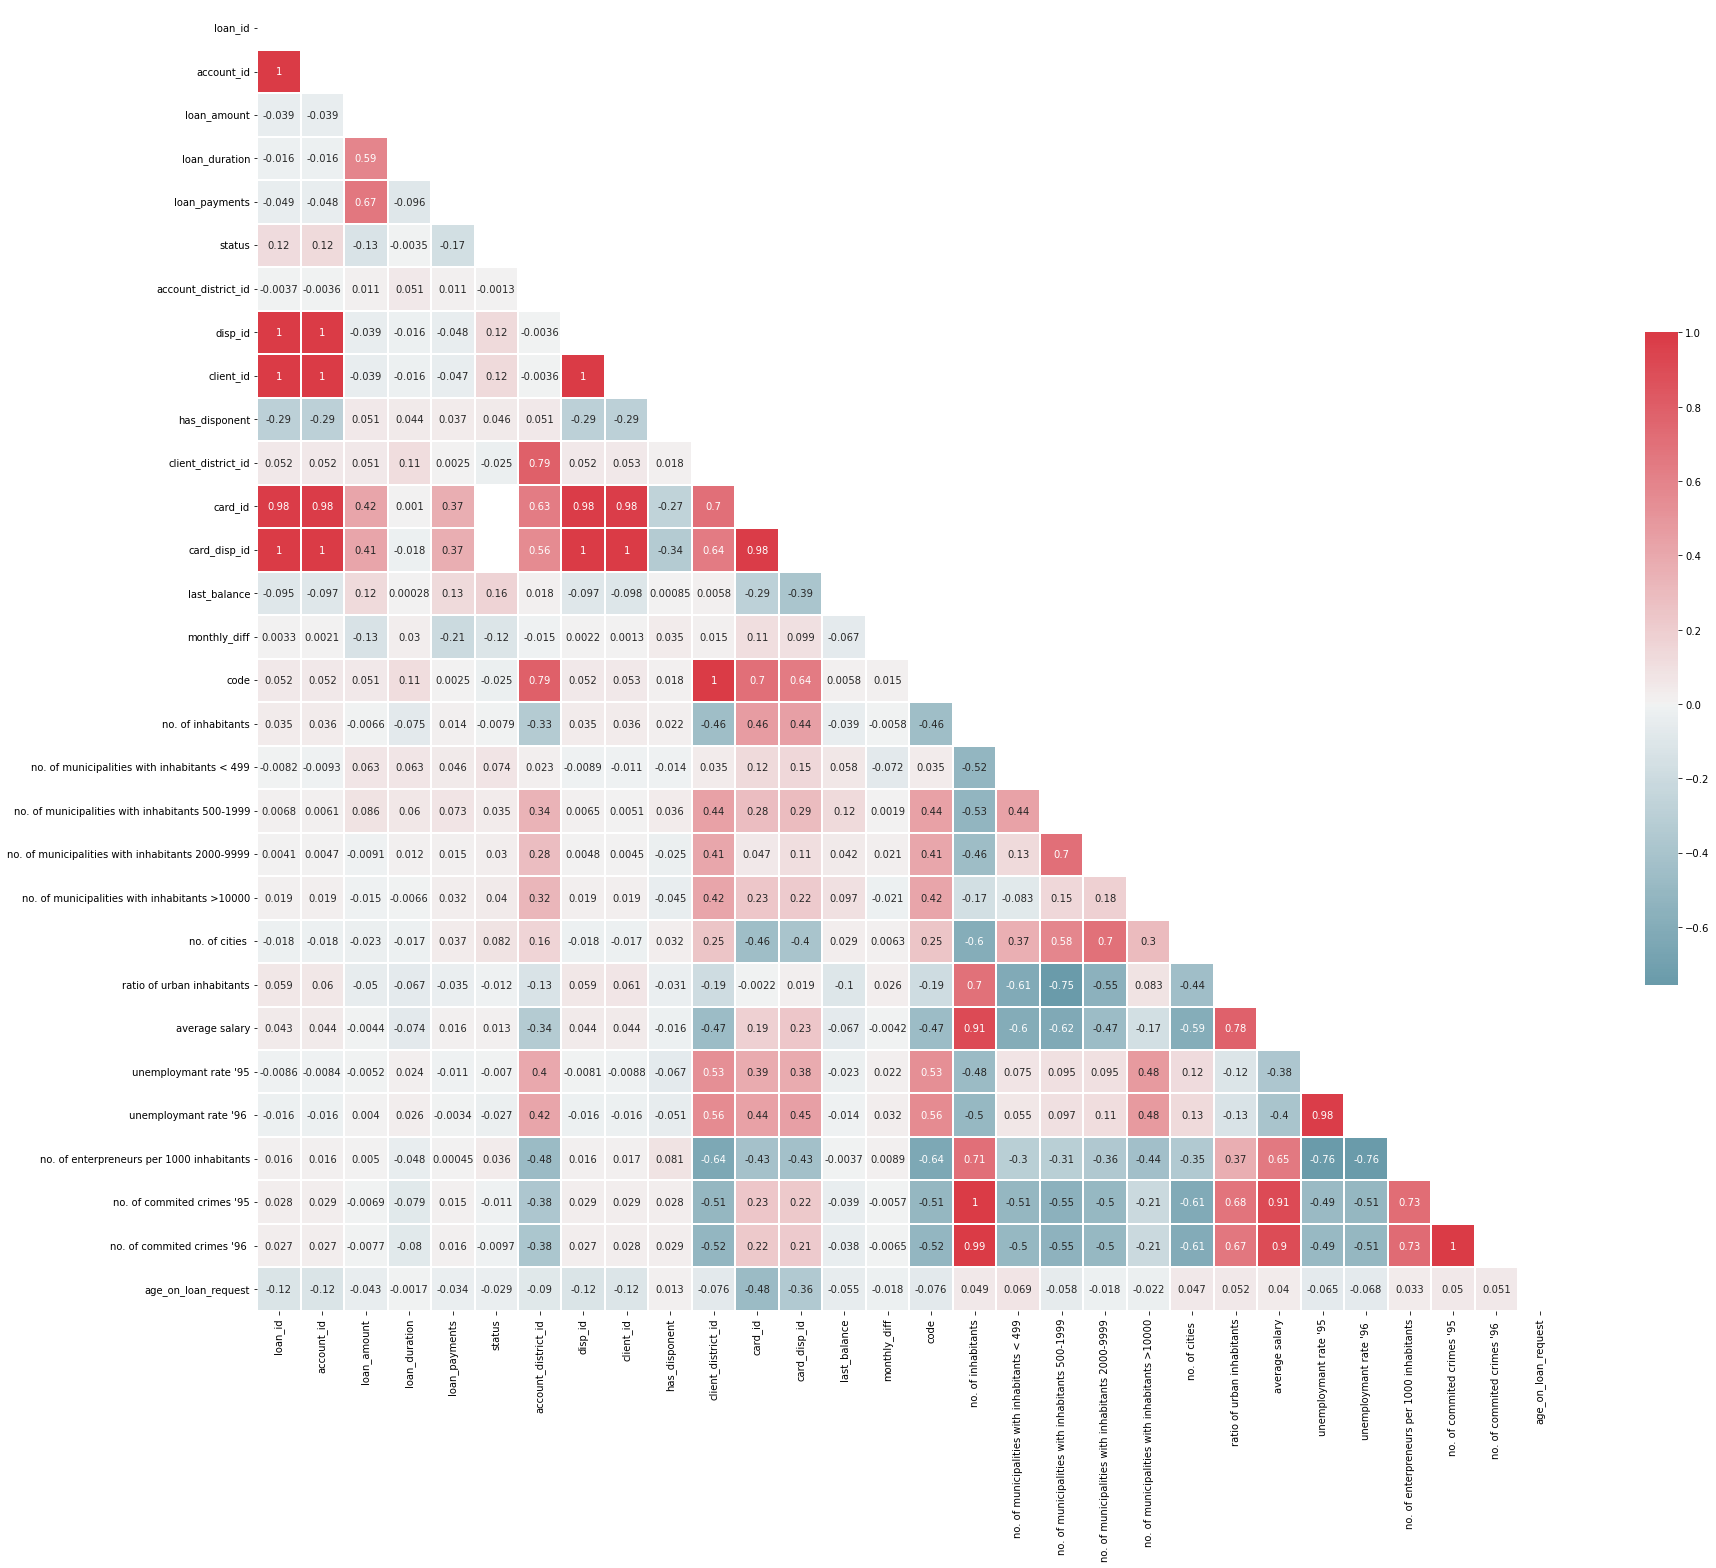

In [17]:
def get_correlation(df):

    corr = df.corr()
    mask = np.zeros_like(corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True


    plt.subplots(figsize=(30,24))

    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    ax = sns.heatmap(corr, mask=mask, cmap=cmap, center=0,square=True, linewidths=.1, cbar_kws={"shrink": .5}, annot = True)

    y_lim = ax.get_ylim();
    ax.set_ylim(np.ceil(y_lim[0]), np.floor(y_lim[1]))
    

    plt.show()

get_correlation(data)
